# NLP Text Article Classification for US Economic Content

With this workbook, we will explore the creation of an NLP model that can
classify article text to determine if it is an article about US economics or not. 

The dataset we're using is the `US Economic News Articles (Useful for NLP)` dataset
from kaggle: https://www.kaggle.com/datasets/heeraldedhia/us-economic-news-articles.
This dataset provide the article content and a binary classification for whether or
not the article is relevant to the US Economy.

We will be using a few classification approaches and show how classic 
statistical modeling for NLP classification tasks may compare against
newer technologies like transformers and NNs.

So first, we will try some high-dimensional learning with traditional
supervised learning methods using vectorization.

The design used for the NN model will be a single output binary classification head
built on top of a pretrained transformer. This may seem like a daunting effort, but
ultimately the transformer will output a rich embedding of the textual content that
we can then use for our simple 2 layer neural-network classifier. 

The data and a copy of this workbook will be available here: https://github.com/colinrgodsey/cu-msds-dtsa-5509

Let's begin.

In [2]:
from transformers import AutoTokenizer, TFAutoModel
from transformers.optimization_tf import create_optimizer
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

if not tf.test.is_gpu_available():
  print('Not connected to a GPU')
else:
  print('gpu found')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Not connected to a GPU


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Exploration ##

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/colinrgodsey/cu-msds-dtsa-5509/main/US-Economic-News.csv", encoding_errors="replace")

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               8000 non-null   int64  
 1   _golden                8000 non-null   bool   
 2   _unit_state            8000 non-null   object 
 3   _trusted_judgments     8000 non-null   int64  
 4   _last_judgment_at      8000 non-null   object 
 5   positivity             1420 non-null   float64
 6   positivity:confidence  3775 non-null   float64
 7   relevance              8000 non-null   object 
 8   relevance:confidence   8000 non-null   float64
 9   articleid              8000 non-null   object 
 10  date                   8000 non-null   object 
 11  headline               8000 non-null   object 
 12  positivity_gold        0 non-null      float64
 13  relevance_gold         0 non-null      float64
 14  text                   8000 non-null   object 
dtypes: b

The authors have provided some metadata in this dataset. Most of it is not
useful for our task, but they do provide a confidence score. Presumambly, this
data was scraped using some undisclosed system (or possibly another 
classifier) to pre-classify this data.

Lets see if there's any good relationship between the confidence and the
length of the article. This may provide us a good clue on which data is
higher quality. 

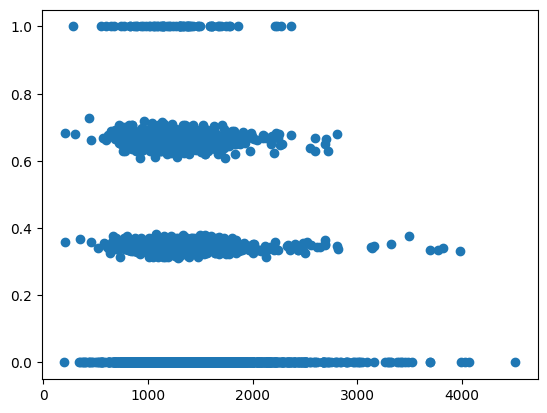

In [4]:
df['length'] = df['text'].str.len()

plt.scatter(df.length, df['positivity:confidence'])
plt.show()

The larger articles indeed seem to have a lower confidence. This is good news
for us considering this is an NLP project, and longer data will make for more
complicated analysis. Let's remove all articles where there are more than 2500
characters, and anything with articles less than 300 characters.

In [5]:
size_prior = len(df)
df = df[df.length < 2500]
df = df[df.length > 300]
delta = size_prior - len(df)
print(f'Removed {delta} long samples.')

Removed 293 long samples.


We want to reduce our dataset a little
bit for this workbook to aid in training times, so we take only articles
with a higher confidence rate. 

In [6]:
print(df['relevance:confidence'].describe())

# remove a small amount of low confidence data
df = df[df['relevance:confidence'] > 0.68]

print(df['relevance:confidence'].describe())

count    7707.000000
mean        0.857493
std         0.166459
min         0.336400
25%         0.669600
50%         1.000000
75%         1.000000
max         1.000000
Name: relevance:confidence, dtype: float64
count    5334.000000
mean        0.946603
std         0.116605
min         0.680100
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: relevance:confidence, dtype: float64


## Balance the Data

The problem we're persuing is best handled with balanced training and validation
data. This set could be later reshuffled to introduce more varienty, but for this
body of work we're just going to balance the whole dataset by removing some
non-us-economy articles and work with those results.

Below, we show the distribution before and after rebalancing.

In [7]:
print(df.relevance.describe())

# idempotent, run it all you like. run the above if you want a new shuffle
n_total = len(df)
df_true = df[df.relevance == 'yes']
df_false = df[df.relevance == 'no']
n_samples = min(len(df_true), len(df_false))
df_true = df_true.sample(n_samples)
df_false = df_false.sample(n_samples)

df = pd.concat([df_true, df_false])

# shuffle
df = df.sample(frac = 1)

df.relevance.describe()

count     5334
unique       2
top         no
freq      4727
Name: relevance, dtype: object


count     1214
unique       2
top        yes
freq       607
Name: relevance, dtype: object

## Traditional Supervised Learning Models ##
We'll first explore using traditional supervised learning techniques. This will involve
using word lemetization and vectorization to reduce the dimensionality of our
input as much as possible and simplify the english language representation so we can
perform lower dimension analysis on the language data. Even with this effort, we
will still have several hundred dimensions available for our text vector.

In [303]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn

df['stext_final'] = df.text
df['stext'] = [entry.lower() for entry in df['text']]
df['stext'] = [word_tokenize(entry) for entry in df['stext']]
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index, entry in enumerate(df['stext']):
    fwords = []
    wordlem = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            wordf = wordlem.lemmatize(word,tag_map[tag[0]])
            fwords.append(wordf)
    df.iloc[index].at['stext_final'] = ' '.join(fwords)

print(df.text)
print(df.stext_final)

/tmp/ipykernel_8043/1385147134.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[index].at['stext_final'] = ' '.join(fwords)


1778    NEW YORK -- The ailing U.S. economy could soon...
4740    The economic boom of the 1990s raised the inco...
68      Some people continue to believe, or at least s...
5325    NEW YORK���Despite the stock market�۪s broad r...
3973    Kudos to the Journal for getting it right in t...
                              ...                        
1045    THE JOBLESS RATE ROSE to 7% in September from ...
7000    With the stock market continuing to fall from ...
2929    NEW YORK -- "On your mark. Get set. Go . . . s...
1611    Author: Abhrajit Gangopadhyay</br></br>NEW DEL...
7961    market for |the year will be buoyant. It will ...
Name: text, Length: 1214, dtype: object
1778    NEW YORK -- The ailing U.S. economy could soon...
4740    The economic boom of the 1990s raised the inco...
68      Some people continue to believe, or at least s...
5325    NEW YORK���Despite the stock market�۪s broad r...
3973    Kudos to the Journal for getting it right in t...
                              ..

Next we prepair our data split and our word vectorizer. The word
vectorization will finally break down our reduced list of
words into numerical dimensions that we build a model against.

We chose 1000 dimension for our word vectorization.

In [320]:
from sklearn.feature_extraction.text import TfidfVectorizer

num_features = 1000

print(dfs.stext_final.head())

dfs = df[df.stext_final.notna()].copy()

vec = TfidfVectorizer(max_features=num_features)
vec.fit(dfs.stext_final)

x_all = dfs.stext_final
y_all = dfs.relevance == "yes"

val_split = 0.2
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=val_split)

x_all = vec.transform(x_all)
x_train = vec.transform(x_train)
x_test = vec.transform(x_test)

print(df.relevance.describe())

print(x_train.shape, y_train.shape)

1778    NEW YORK -- The ailing U.S. economy could soon...
4740    The economic boom of the 1990s raised the inco...
68      Some people continue to believe, or at least s...
5325    NEW YORK���Despite the stock market�۪s broad r...
3973    Kudos to the Journal for getting it right in t...
Name: stext_final, dtype: object
count     1214
unique       2
top         no
freq       607
Name: relevance, dtype: object
(971, 1000) (971,)


## SVM

For our first traditional model, we'll use SVM. We start by doing a grid
search to find the ideal hyperparameters for our incredibly high dimensional
data we now have.

In [324]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV

space = np.logspace(-5, 5, num=6, base=2)

grid = GridSearchCV(SVC(), cv=3,
                   param_grid={'C': space, 'gamma': space}).fit(x_train, y_train)

In [306]:
def plotSearchGrid(grid, params):
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid[params[0]]), len(grid.param_grid[params[1]]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel(params[1])
    plt.ylabel(params[0])
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid[params[1]])), grid.param_grid[params[1]], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid[params[0]])), grid.param_grid[params[0]])
    plt.title('Validation accuracy')
    plt.show()

def print_roc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    auc_neat = int(auc * 1000) / 1000

    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
    ax.plot(fpr, tpr, lw=2, label=f"ROC (AUC={auc_neat})")
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlabel("False Positive Rate", fontsize=16)
    ax.set_ylabel("True Positive Rate", fontsize=16)
    ax.set_title(f"ROC Curve", fontsize=16)
    ax.legend(loc="best")
    plt.show()

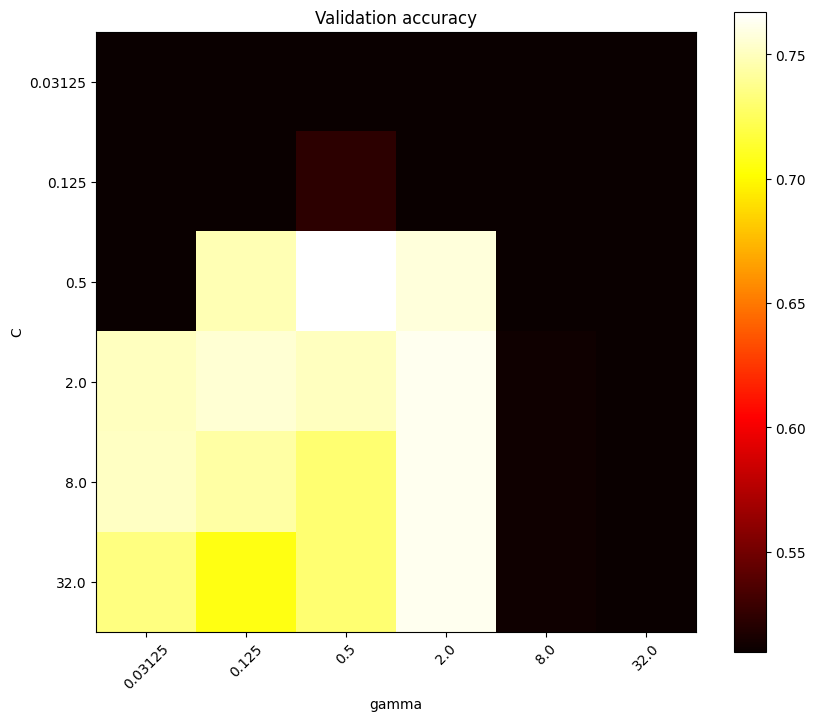

In [307]:
plotSearchGrid(grid, ["C", "gamma"])

It appears the ideal hyperparameters for SVC are C=0.5 and gamma=0.5. We'll move 
ahead with this assumption and use the best fit model from the grid search and
continue our analysis.

In [328]:
from sklearn.metrics import accuracy_score

clf = grid.best_estimator_

scores = cross_val_score(clf, x_all, y_all)
acc = accuracy_score(y_test, clf.predict(x_test))
print("cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
print(f"simple accuracy {acc}")

cross-val mean-accuracy: 0.765
simple accuracy 0.7736625514403292


It seems SVM is shockingly good at this type of NLP classification problem, with
a simple accuracy score of 77% on the test set, and a 76% on the cross-validation. 
Let's move on to using a random forest to see if we can produce something even better.

## Random Forest ##

In [331]:
from sklearn.ensemble import RandomForestClassifier

grid = GridSearchCV(RandomForestClassifier(), cv=3,
                   param_grid={
                    'n_estimators': [10, 30, 50, 100, 150], 
                    'max_depth': [1, 5, 10, 30, 50],
                   }).fit(x_train, y_train)

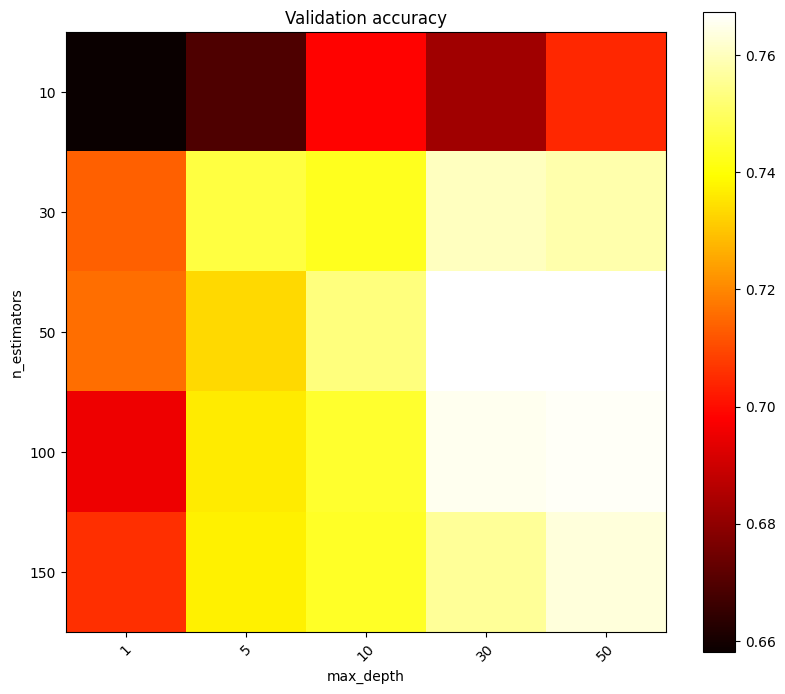

In [332]:
plotSearchGrid(grid, ["n_estimators", "max_depth"])

Wow, apparently an ensemble classifier also works pretty well too at 
max depth of 50, and 50 estimators.

Let's dive a little deeper into the performance.

In [335]:
from sklearn.metrics import roc_curve, roc_auc_score

clf = grid.best_estimator_

y_pred = clf.predict(x_test)
scores = cross_val_score(clf, x_all, y_all)
acc = accuracy_score(y_test, y_pred)

print("cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
print(f"simple accuracy {acc}")

cross-val mean-accuracy: 0.759
simple accuracy 0.7613168724279835


The random forest also does remarkably will with NLP text classification!
The cross validation comes in at 75%, with simple test set accuract at 76%.

It's now time to break out the big guns. Lets see if a transformer model can
do even better!!

## Transformer Data Preprocessing
Now that we have a fully balanced dataset, we need to prepare our data for model 
training. We're going to be using the distilbert transformer as the processor for our 
classification model. Distilbert is a reduced version of BERT that shares the same
general architecture. Throughout this workbook we may use BERT and distilbert 
interchangeably. 

To prepare the text data for the transformer, we will
be combining the headline and article body together using the transformers
preferred separator, which is defined in the tokenizer. 

The tokenizer will also prepend a special `cls` token at the start of each input,
which is a special token in some transformers that are trained with sequence
classification tasks. This token is generally placed first in the text content
and will produce special classification values in the 0 output of the 
transformer's hidden state.

BERT-based models have a sequence limit of 512 tokens. This is a bit unfortunate
for article classification, because many of these sequences are longer than 512 
words (which best case would be 512 tokens). Further work on this project would
involve a more advanced processing system, either based on ensemble classification
for different chunks of the article, or perhaps even just breaking apart a single
article into several different independent samples. After all, an article of this
length should probably stay on topic, and there's a good chance that the independent
chunks would still be valid samples.

The tokenizer and model will both be pulled from HuggingFace, which is a fantastic
repository and SDK for all sorts of models, and they have an especially good
transformers library. Each transformer comes with its own tokenizer which gives
us the functionality we need to effictively convert our text into the tokenized
representation the model expects.

In [8]:
transformer_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(transformer_name)

def clean_text(str):
  str = str.replace("</br>", ' ')
  return str

df['input'] = df.headline + (' ' + tokenizer.sep_token + ' ') + df.text
df['input'] = df.input.apply(clean_text)

df[['input', 'relevance']]

,input,relevance
3649,Stock Market Quarterly Review -- Essay: Feel-G...,yes
7273,Long Term Interest Rates Have Climbed Back Aga...,no
2591,"Euro Upside Is Seen, for Now [SEP] Author: Bra...",yes
580,U.S. Trade Gap Shrank Slightly during January ...,yes
3316,Several Banks Show Rebound From Deficits --- L...,yes
...,...,...
391,Dollar Rises Against Yen Despite Data [SEP] Au...,yes
5954,Fannie Mae's Profit Surged In 1st Quarter: [SE...,no
687,RJR Nabisco Seeks to Cut Interest Rates on $6 ...,no
4597,Market Closes Mixed After Early Slump [SEP] NE...,no


Below we show one of the samples as it is before tokenization, and
then we reverse the tokenization to get a better idea of what the model
will actually be seeing. You can see that punctuation is simplified, casing 
is removed, and some words are broken down into more simple representations.

In [9]:
test_input = df.input[df.relevance == 'yes'].iloc[5]
print(test_input)

test_encoded = tokenizer([test_input], padding=True, truncation=True)
test_decoded = tokenizer.decode(test_encoded.input_ids[0])
print(test_decoded)

Leading Indicators Fell Last Month; Decline is Fourth in a Row; Hurricanes, High Oil Prices Slowed Growth of Economy [SEP] WASHINGTON -- The Conference Board's composite index of leading indicators slipped in September for the fourth straight month, signaling that the economic soft patch will persist.  Separately, the U.S. Labor Department reported that the number of workers filing first-time applications for unemployment benefits dropped by an unexpectedly steep 25,000 last week, a decline that may have been skewed by the holiday-shortened week.  The Conference Board, a private research group in New York, reported that its composite index of leading indicators fell by 0.1% to a reading of 115.6 in September, after August's 0.3% decline. The slightness of the declines in the past four months seems to argue against invoking the economists' rule of thumb that three consecutive declines in the index signal a recession.  "While the leading index is not yet signaling a downturn, the growth 

Now that we have our `input` column prepared, we need to break the data apart
into our final training and validation pairs. 
After splitting, we convert the `relevance` field from yes/no to a binary
1/0. For the `input` column, we then apply the tokenizer which gives us the correctly
formated tensorflow input we will use for training.

The input data needs to take on a rather odd form for this transformer model. If you
look at the output in this next code cell, you'll see that input data is actually 
a map with the keys for 2 different inputs, and the value of each being a uniform 
input tensor for the dataset. This is the Keras and Tensorflow way of handling multiple
inputs: you can still treat the input as a single X value, but internally it maps
to different named tensors that the model takes in.

In the case of a BERT based transformer, we need to provide an input for 
`input_ids`, which is the integer tensor of tokens, and `attention_mask` which
is a necessary input the blocks the attention mechanism for reacting to tokens
that aren't there. This is slightly odd, but necessary, given that the model
can only accept a rigidly shaped input (with except to batch size) that may 
represet a block of text that is smaller than the maximum size it can take.

In [10]:
val_split = 0.20
max_length = tokenizer.model_max_length
random_seed = 2857

def prepare_data(x, y):
  x = tokenizer(x.tolist(), padding=True,
                truncation=True, return_tensors="tf")
  x = dict(x)
  y = tf.convert_to_tensor(y)
  y = tf.cast(y, tf.uint8)
  return x, y

x = df.input
y = df.relevance == "yes"

x_train, x_test, y_train, y_test = train_test_split(
  x, y, test_size=val_split, random_state=random_seed)

x_train, y_train = prepare_data(x_train, y_train)
x_test, y_test = prepare_data(x_test, y_test)

print(f'len train: {len(x_train)}, len test: {len(x_test)}')
print(x_train)
print(y_train)

len train: 2, len test: 2
{'input_ids': <tf.Tensor: shape=(971, 512), dtype=int32, numpy=
array([[  101,  2188,  4341, ...,     0,     0,     0],
       [  101,  1996,  3361, ...,     0,     0,     0],
       [  101,  2457,  2613, ...,     0,     0,     0],
       ...,
       [  101, 12430,  3976, ...,     0,     0,     0],
       [  101,  5374,  1025, ...,     0,     0,     0],
       [  101,  9387,  3420, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(971, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}
tf.Tensor(
[1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1
 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0
 1 0 0 1 0 1 1 1 0 1 1

## The Model Architecture

Below we define the entire model. HuggingFace offers up most of their models
in a Keras format that can be easily extended. In Keras, any model can be 
used as a layer in a new model. This is a great technique generally called
"transfer learning" in which you use all or part of a pretrained model in 
a new model. For our purpose, we want to lean pretty heavily on the pretrained
language ability of the distilbert model. The training pattern used here is 
slightly odd, and will be explained later on.

The outline of our model is as follows:
1. We define our input as an array of named inputs that mirror the input
structure of the distilbert model. 
2. We pass this input to the loaded and pretrained distilbert model that
we loaded using the HuggingFace `transformers` library.
3. The output at this point is a tensor of Bx512x768 shape. The BERT
transformer maintains a pretty stable shape throughout its attention layers,
and this is the final output of those layers. See the footnote on BERT hidden 
state below for how we handle this output.
4. The reconfigured output from BERT is then fed into a layer normalization, 
which is the generally accepted form
of normalization for NLP tasks, then we apply a dropout at 30%, which is
a pretty standard NN technique to encourage generalization. Dropout pushes
the model towards lower variance, but you need to strike the right balance that
also gives a low bias. 
5. This output is the fed into our pre-classifier layer. 
This is a dense (fully-connected) layer that uses GELU activation (a more 
statistically sound verion of the rectified linear activation). A preclassification
layer provides a high dimentional feature pool that will be used by the final
neuronwe'll use for our classifier. We chose 1024 features for this layer to
account for the high dimensionality (768 x 2) of the data being fed to it. 
6. We use dropout after the pre-classifier to again encourage 
generalization. 
7. We finally feed the pre-classifier output into our classifier neuron
which uses the sigmoid activation. 

We then set up some training parameters before we compile the Keras model. We
pick an MSE error for the optimizer, as it tends to perform a little better
than BCE when using a single classifier output, althought BCE would also
generally work. 

We define a training function that lets us specify which part of the model
we're trying to train and a starting learning rate. We use the start learning
rate to define a polynomial learning rate decay that is again used to encourage
generalization.

The dropouts were searched for by hand. The goal was to find a dropout that would 
give us stable training while keeping the training loss *higher* than the validation
loss. This is generally a sign that you're avoiding as much overfitting as possible
by preventing the training loss (which includes the dropouts) from never getting
as low as the validation loss. Keeping this behavior while still lowering the
validation loss over time is the ideal balance of variance and bias. Dropouts
are very important for transformer models as they represet an extremely high
dimensional set of data that can overfit very easiily. 

### Footnote: Bert Hidden State ###
The 512 different outputs contain
a full context related to each word of the 512 inputs. This
per-input-token context is not incredibly important, except for the first
token on BERT, which is the `[CLS]` token. This is a specifically designed token
for classification, but the paper does mention that this may not actually be
important or necessary. We split the difference and make a new embedding that
concatenates the full output of the CLS token with an average of the 
remaining tokens, giving us a 2x768 input for our pre-classification layer.

In [11]:
batch_size = 16
max_epochs = 25
model_save_path = "ml-supervised-final"

tf.random.set_seed(random_seed)
weight_init = tf.keras.initializers.TruncatedNormal(stddev=0.02)
weights_loaded = False

input = [
  tf.keras.layers.Input([max_length], dtype=tf.int32, name='input_ids'),
  tf.keras.layers.Input([max_length], dtype=tf.int32, name='attention_mask')
]

xform = TFAutoModel.from_pretrained(transformer_name)
hidden_state = xform(input).last_hidden_state

avg = tf.math.reduce_mean(hidden_state[:, 1:], axis=-2)
avg = tf.keras.layers.LayerNormalization()(avg)
cls = hidden_state[:, 0]

x = tf.keras.layers.Concatenate()([avg, cls])
x = tf.keras.layers.Dropout(0.30)(x)
x = tf.keras.layers.LayerNormalization()(x)
preclassifier = tf.keras.layers.Dense(
  1024, kernel_initializer=weight_init, activation='gelu')
x = preclassifier(x)
x = tf.keras.layers.Dropout(0.50)(x)
classifier = tf.keras.layers.Dense(
  1, kernel_initializer=weight_init, activation='sigmoid')
x = classifier(x)

model = tf.keras.Model(inputs=input, outputs=x)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

def train(lr, xform_trainable=None):
  if xform_trainable is None:
    xform.trainable = True
    preclassifier.trainable = True
    classifier.trainable = True
  else:
    xform.trainable = xform_trainable
    preclassifier.trainable = not xform_trainable
    classifier.trainable = not xform_trainable

  if not xform_trainable:
    lr = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        power=0.5,
        decay_steps=int(len(y_train) / batch_size * max_epochs),
        end_learning_rate=1e-9,
    )

  opt = tf.keras.optimizers.Adam(lr)

  # compile will force the graph to recache after changing trainability
  model.compile(optimizer=opt, loss="mse", metrics=['accuracy'])
  model.summary()

  if weights_loaded:
    print("skipping training, weights loaded")
    return dict()

  return model.fit(
    x_train, y_train, batch_size=batch_size, epochs=max_epochs,
    validation_data=(x_test, y_test),
    callbacks=[earlystop])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers.py:1

In [12]:
try:
  model.load_weights(model_save_path)
  weights_loaded = True
  print("weights loaded!")
except:
  pass

weights loaded!


## Phase 1 Training ##

The first training phase here trains the classifier without training the transformer
itself. This is a great way to start training as at this phase the classifier
is force to learn all it can from the generalized NLP output of the model without
finetuning (and potentially overfitting) the language focus. The learning rate here
was picked manually, but could have been search for using the Keras hyperparamter
tuning framework. It was not worth implementing that for the purpose of this 
workbook.

In [12]:
history = train(lr=1e-5, xform_trainable=False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 512, 768),                                                   
                                 hidden_states=None                                           

2023-08-16 01:00:18.227339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-16 01:00:18.372929: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x10926c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-16 01:00:18.372953: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-08-16 01:00:18.395234: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-16 01:00:18.602862: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 [==============================] - 18s 234ms/step - loss: 0.2490 - accuracy: 0.5388 - val_loss: 0.2288 - val_accuracy: 0.6988
Epoch 2/25
63/63 [==============================] - 14s 223ms/step - loss: 0.2393 - accuracy: 0.5881 - val_loss: 0.2142 - val_accuracy: 0.7430
Epoch 3/25
63/63 [==============================] - 14s 223ms/step - loss: 0.2246 - accuracy: 0.6616 - val_loss: 0.2025 - val_accuracy: 0.7550
Epoch 4/25
63/63 [==============================] - 14s 226ms/step - loss: 0.2186 - accuracy: 0.6747 - val_loss: 0.1951 - val_accuracy: 0.7510
Epoch 5/25
63/63 [==============================] - 14s 226ms/step - loss: 0.2132 - accuracy: 0.6949 - val_loss: 0.1898 - val_accuracy: 0.7550
Epoch 6/25
63/63 [==============================] - 14s 224ms/step - loss: 0.2060 - accuracy: 0.6858 - val_loss: 0.1840 - val_accuracy: 0.7550
Epoch 7/25
63/63 [==============================] - 14s 224ms/step - loss: 0.1991 - accuracy: 0.7190 - val_loss: 0.1797 - val_accuracy: 0.7590
Epoch 8/25

## Phase 1 Results ##

We can see an ideal loss curve for our training and validation sets below.
This indicates we've reached an acceptable tradeoff between bias and variance.
The dropout introduced random noise to only the training process, which reduces
variance in the training, resulting in a lower loss for our validation set. Too
much dropout would result in a higher bias, showing an inability to learn. Having our
validation loss curve still improve every epoch while being below our training loss
is ideal.

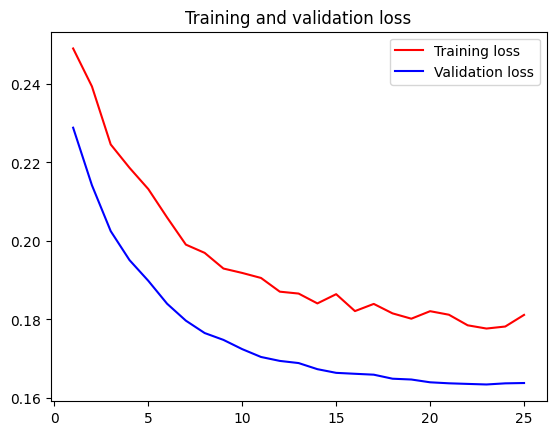

In [13]:
def plot_loss():
  epochs = range(1, len(history.history['loss']) + 1)
  plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
  plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_loss()

## Phase 2 Training ##

Our second training phase allows the entire model to learn. This is a much
more time consuming operation as we're training 67M variables instead of 
just 1.6M variables. When working with transformers, this process is
generally referred to as "fine tuning", which allows the transformer to build
more rich representations of a subset of the language- in this case its 
building a more rich representation of the language around news articles.

We use an even lower learing rate here as transformers can easily overfit
during finetuning, and the classifier head should already be making
good use of the existing NLP output.

In [14]:
history = train(lr=1e-6, xform_trainable=None)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 512, 768),                                                   
                                 hidden_states=None                                           

## Phase 2 Results ##
We can see here we still succesfully met our goal of avoiding overfitting
because our validation loss did not start to increase again over time. But we are
getting pretty close to that scenario, as we can see our training loss shoot
past our validation loss. 

We made the most of fine tuning training, lowering our validation loss a little
bit further, and approaching the most we can make of this dataset.

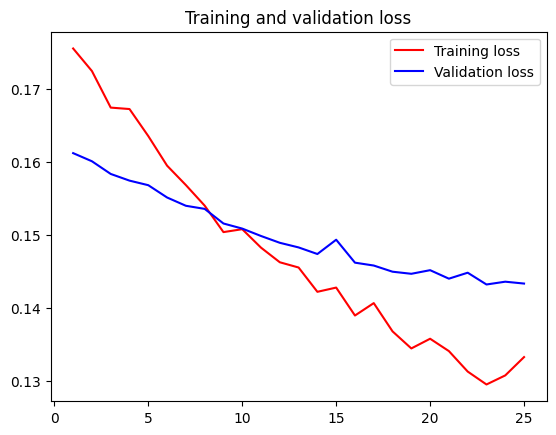

In [15]:
plot_loss()
#benchmark val_loss 0.1462

We save our model weights here as this training process takes quite a long
time, and we have reached acceptable hyperparameter tuning.

In [16]:
if not weights_loaded: model.save_weights(model_save_path)

Now that we have our model and do a deeper dive into its performance.
Let's take our validation set and produce our final scoring for our analysis.

In [14]:
y_score = []
for i in range(len(x_test['input_ids'])):
  input = {
    "input_ids": x_test['input_ids'][i],
    "attention_mask": x_test['attention_mask'][i],
  }
  pred = model(input)
  y_score.append(pred[0, 0])

y_score = np.array(y_score)
y_pred = np.round(y_score)
print(y_score.shape)

(243,)


### ROC Curve ###
We plot our ROC curve here which shows that we have indeed produced a model
capable of classifying our US Economy news articles, although not perfectly.

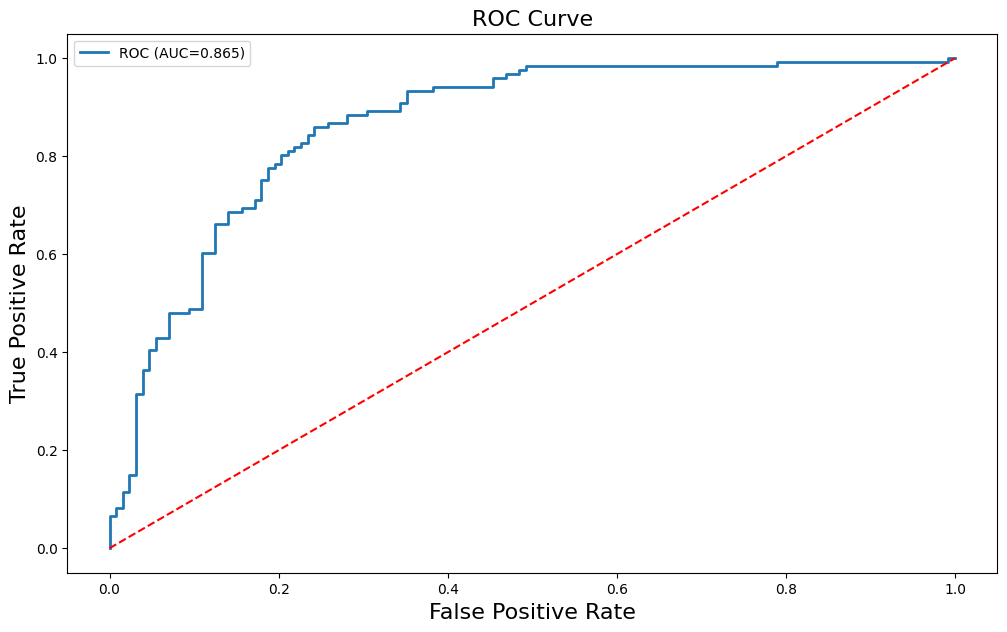

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)
auc_neat = int(auc * 1000) / 1000

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(fpr, tpr, lw=2, label=f"ROC (AUC={auc_neat})")
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
ax.set_title(f"ROC Curve", fontsize=16)
ax.legend(loc="best")
plt.show()

## Accuracy Metrics ##
We can see that we are producing decent accuracy metrics. The accuracy
we've produced is higher than the benchmark set by the dataset publisher!

Our recall is close to 90%, and simple accuracy is close to 79%! Let's look at the confusion matrix below
to get a better sense of where this model fails.

In [17]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

pre, rec, fbeta, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
acc = accuracy_score(y_test, y_pred)

print(f'Precision: {pre}, Recall: {rec}, F-Beta: {fbeta}')
print(f"simple accuracy {acc}")

Precision: 0.7394366197183099, Recall: 0.8898305084745762, F-Beta: 0.8076923076923077
simple accuracy 0.7942386831275721


## Confusion Matrix ##

The confusion matrix below shows that model is in fact very good at
predicting if a new article is about the US Economy. Unfortunately it
seems to suffer from a good amount of false positives. This could be due to
many issues, but I like to believe it's because of the fact that as a US Citizen,
the state of our economy bleeds into almost everything we talk about nowadays,
and is probably inescapable in our news.

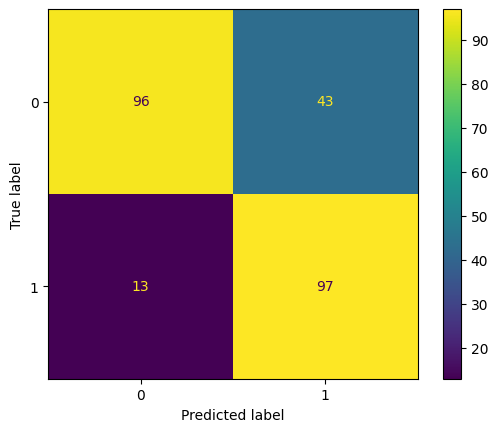

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

## Conclusion ##

We sucesfully used the dataset from Kaggle to train a bunch of different
types of models to classify news articles as to whether or not they are about
the US Economy. All models met or exceeded the benchmarks produced by the
dataset publisher.

We did a dive into different ways to handle NLP tasks with supervised learning.
We started out by exploring tokenization and vectorization techniques that
can represent text in a high dimensional space suitable for use with basic supervised
learning teqchniques, and we evaluated the models.

We then sucesfully trained a transformer-based
classification model to identity news articles about the US Economy. We've 
showcased some of the complications that arise when using transformers,
but also how effective they can be at NLP tasks. Their ability to produce
a rich high-dimensional embedding of the input tasks opens up many opportunities.

We then dived into an analysis of the performance of thes models, and produced an
interpretation of our results.

The transformer model did come on top, likely due to its dense and rich representation
of text content. Unlike the traditional models we used above, transformers have
an incredibly ability to understand the context that text is in, and when using a  
pretrained transformer, it has the ability to associate textual meaning even
when it encounters words that weren't in the training set, which is likely to produce
a more robust model when used in the wild.
